In [1]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import matplotlib.colors as mcolors

# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, OLSModel
from utils import set_randomness

In [2]:
def train_model(lr, x, y, f, admittime, categorical_columns):
    """
    Train OLS model with given learning rate and track results
    """
    n = len(x)
    d = x.shape[1]
    model = OLSModel(torch.zeros((d,)))
    optimizer = GD(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize tracking arrays
    thetas = torch.zeros(n+1, d, dtype=torch.float32)
    ys = torch.zeros(n+1, dtype=torch.float32)
    fs = torch.zeros(n+1, dtype=torch.float32)
    yhats = torch.zeros(n+1, dtype=torch.float32)
    losses = torch.zeros(n+1, dtype=torch.float32)
    gradients = torch.zeros(n+1, d, dtype=torch.float32)
    average_losses = torch.zeros(n+1, dtype=torch.float32)
    average_gradients = torch.zeros(n+1, d, dtype=torch.float32)
    
    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum')
    
    for t in range(n):
        x_t = x[t]
        y_t = y[t]
        f_t = f[t]
        r_t = y_t - f_t
        
        optimizer.zero_grad()
        thetas[t+1] = model.theta.detach().cpu()
        prediction = model(x_t.to(device))
        loss = 0.5 * loss_fn(prediction.squeeze(), r_t.to(device).squeeze())
        loss.backward()
        optimizer.step()
        
        ys[t+1] = y_t.detach().cpu()
        fs[t+1] = f_t
        yhats[t+1] = f_t + prediction
        losses[t+1] = loss.detach().cpu().item()
        gradients[t+1] = model.theta.grad.detach().cpu()
        average_losses[t+1] = losses[:t+1].mean()
        average_gradients[t+1] = gradients[:t+1].mean(dim=0)
    
    df = pd.DataFrame({
        'theta': thetas.tolist(),
        'y': ys.tolist(),
        'f': fs.tolist(),
        'yhat': yhats.tolist(),
        'loss': losses.tolist(),
        'gradient': gradients.tolist(),
        'average gradient': average_gradients.tolist(),
        'average loss': average_losses.tolist(),
        'admittime': [None] + admittime.tolist(),
        'lr': lr
    })
    
    # Add categorical columns
    for col in categorical_columns:
        df[col] = [None] + categorical_columns[col].tolist()
    
    return df

In [3]:
# Set flags and parameters
experiment_name = "multigroup"
show_f = False
save = True
show = False

# Set randomness
set_randomness(0)

# Load and preprocess data
data = pd.read_pickle('./.cache/gradient_boosting.pkl')
data = data.tail(10000)  # Use last 10k samples
data['residuals'] = data['length_of_stay_float'] - data['f']

# Prepare features
categorical_cols = ["ethnicity", "marital_status"]
dummy_df = pd.get_dummies(data[categorical_cols])
order = dummy_df.columns.values.tolist()
xs = torch.tensor(dummy_df.values.astype(float), dtype=torch.float32)
y = torch.tensor(data['length_of_stay_float'].values, dtype=torch.float32)
f = torch.tensor(data['f'].values, dtype=torch.float32)

# Training parameters
lrs = [0, 0.001, 0.01, 0.05]

In [4]:
# Train models with different learning rates
results = []
for lr in tqdm(lrs, desc="Training models"):
    result_df = train_model(lr, xs, y, f, data['admittime'], {col: data[col] for col in categorical_cols})
    results.append(result_df)

# Combine results
combined_df = pd.concat(results, ignore_index=True)
combined_df['norm of avg grad'] = combined_df['average gradient'].apply(np.linalg.norm, ord=np.inf)

# Filter data based on first nonzero gradient
combined_df = combined_df[combined_df.admittime > combined_df[combined_df['norm of avg grad'] != 0].admittime.min()]

Training models: 100%|██████████| 4/4 [00:24<00:00,  6.24s/it]


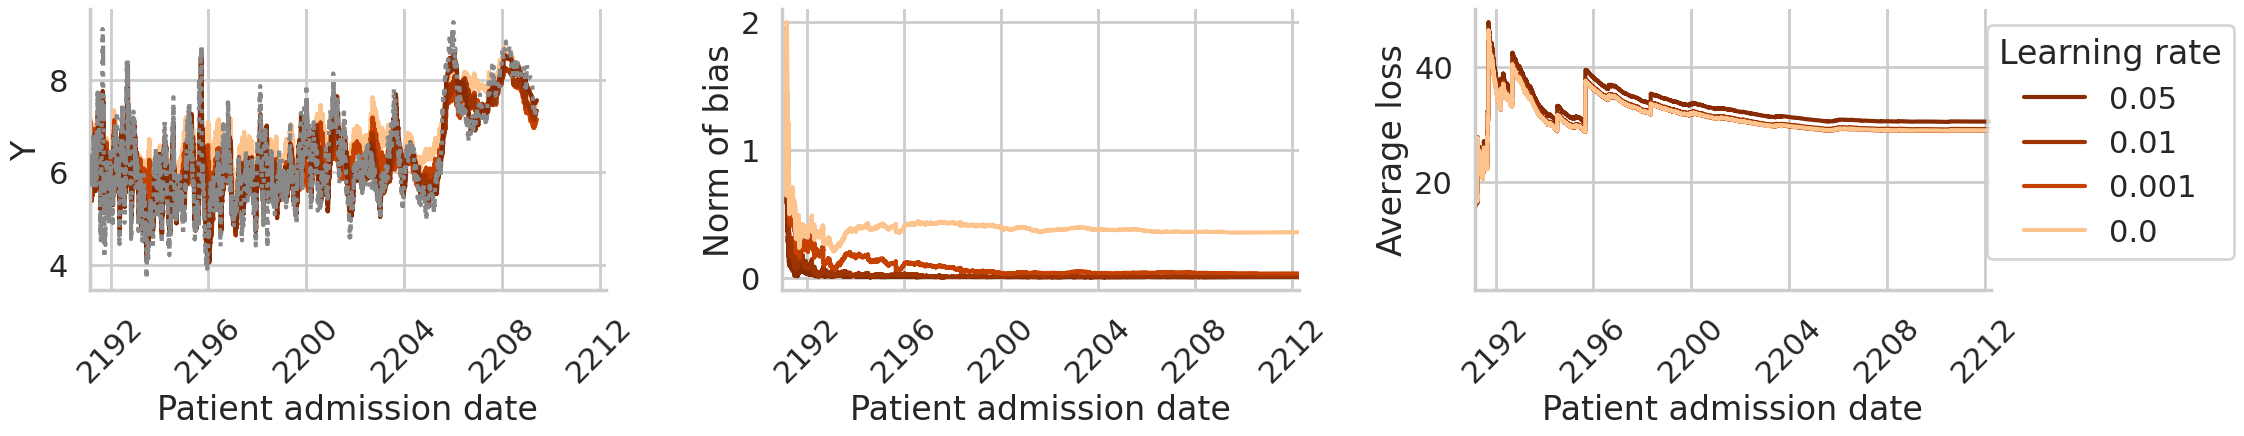

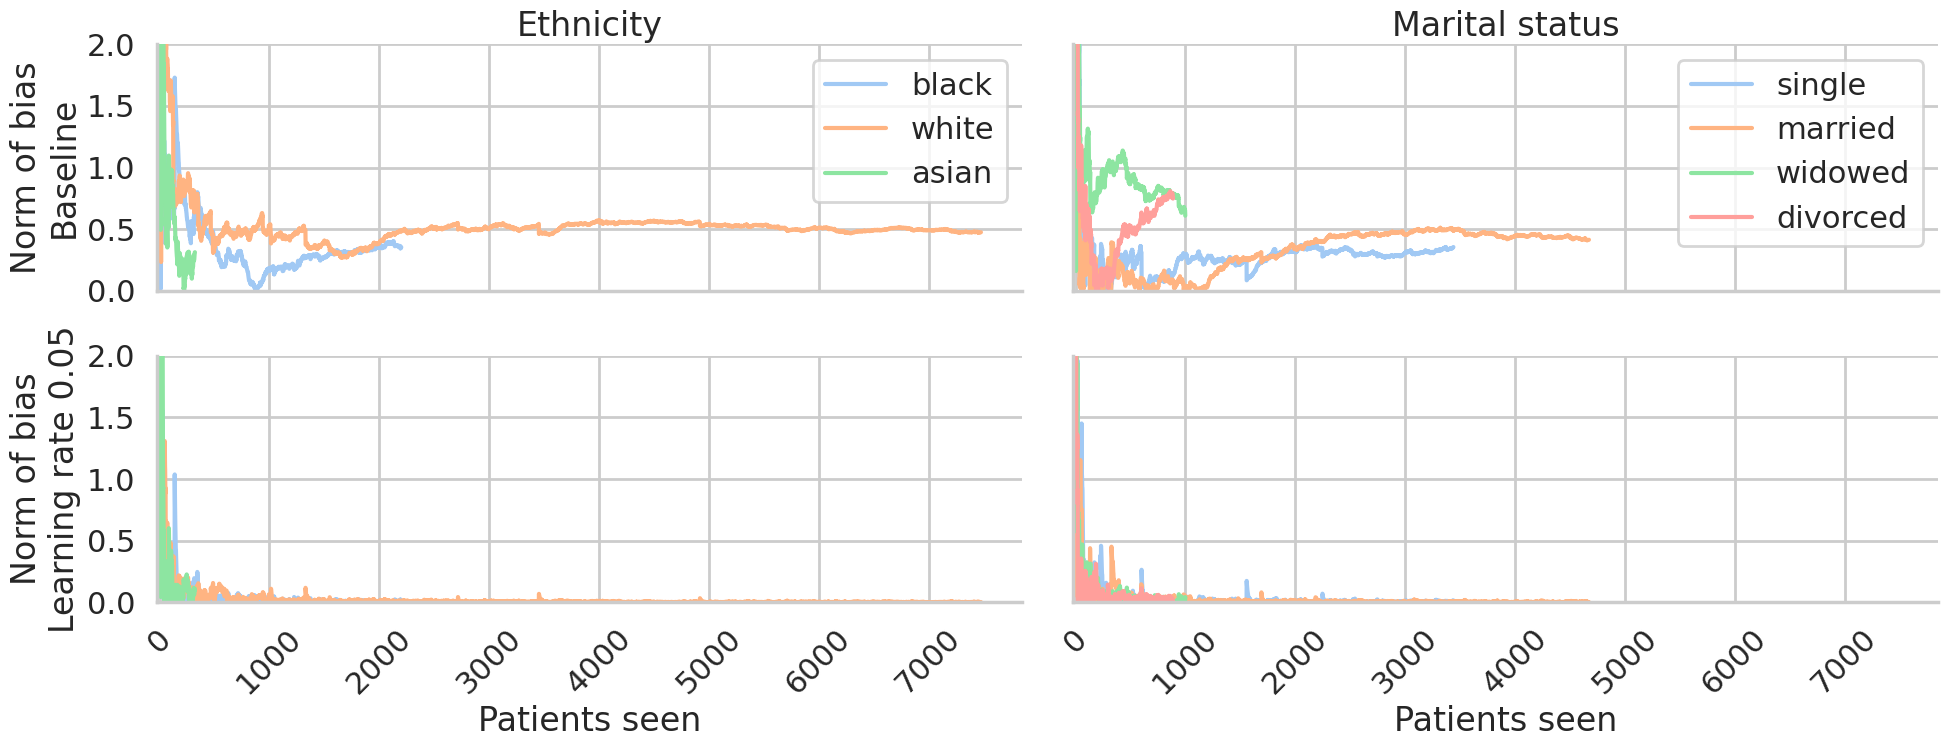

In [5]:
# Set styling
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

# Read from cache
combined_df = pd.read_pickle('.cache/mimic_ols_multigroup.pkl')

# Create color map
lr_cmap = plt.cm.Oranges

# Use logarithmic normalization
# This ensures equal color spacing on a log scale
eps = 1e-8
norm = mcolors.LogNorm(vmin=min(np.array(lrs)+eps)/1000, vmax=max(np.array(lrs)+eps)*2)

# Create the colors by mapping the learning rates to the colormap
hues = {
    lr: lr_cmap(norm(lr+eps)) for lr in lrs
}

# Get learning rates and create ordered lists
lr_values = sorted(combined_df['lr'].unique())
lr_values_reversed = sorted(combined_df['lr'].unique(), reverse=True)

# Plot 1: Time Series Analysis
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=False, sharey=False)

# Define rolling window size
window_size = 100

# Left plot: Rolling average for predictions
# Predictions for each learning rate (plot these first)
pred_df = combined_df.copy()
pred_df['yhat_rolling'] = pred_df.groupby('lr')['yhat'].transform(
    lambda x: x.rolling(window=window_size, center=True).mean()
)
_lp = sns.lineplot(ax=axs[0], data=pred_df,
                  x="admittime", y="yhat_rolling",
                  hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values)
# True values (plot these last)
true_df = combined_df[combined_df.lr == 0].copy()
true_df['y_rolling'] = true_df['y'].rolling(window=window_size, center=True).mean()
sns.lineplot(ax=axs[0], data=true_df,
            x="admittime", y="y_rolling", color="#888888",
            estimator=None, n_boot=0, label="True values", linestyle=":", zorder=10)

if show_f:
    axs[0].plot(combined_df.f, color="#880000")
    
axs[0].set_ylabel("Y")
_lp.get_legend().remove()

# Middle plot: Gradient norm
_lp = sns.lineplot(ax=axs[1], data=combined_df,
                  x="admittime", y="norm of avg grad",
                  hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values_reversed)
axs[1].set_ylabel("Norm of bias")
_lp.get_legend().remove()

# Right plot: Average loss
_lp = sns.lineplot(ax=axs[2], data=combined_df,
                  x="admittime", y="average loss",
                  hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values_reversed)
axs[2].set_ylabel("Average loss")
axs[2].legend(loc="upper right", bbox_to_anchor=(1.5,1), title='Learning rate')

for ax in axs:
    ax.set_xlabel("Patient admission date")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
axs[0].set_xlim([combined_df.admittime.min(),combined_df.admittime.max()])
axs[1].set_xlim([combined_df.admittime.min()+timedelta(days=-60),combined_df.admittime.max()]) # For rendering purposes, the line doesn't appear otherwise
axs[2].set_xlim([combined_df.admittime.min(),combined_df.admittime.max()])
sns.despine(top=True, right=True)
plt.tight_layout()

if save:
    os.makedirs(f'./plots/{experiment_name}', exist_ok=True)
    plt.savefig(f'./plots/{experiment_name}/series.pdf', bbox_inches="tight")
if show:
    plt.show()

# Plot 2: Stratified Analysis
# Drop NaN values in categorical columns
for col in categorical_cols:
    combined_df = combined_df[~combined_df[col].isna()]

# Get unique values for each categorical column
uniques = [combined_df[col].unique() for col in categorical_cols]

# Set up plot grid based on number of learning rates and categorical columns
n_lrs = 2  # We'll show min and max learning rates
fig, axs = plt.subplots(nrows=n_lrs, ncols=len(categorical_cols), 
                       figsize=(20, 8), sharey=True, sharex=True)

# Get min and max learning rates
lr_min = combined_df.lr.min()
lr_max = combined_df.lr.max()
lrs_to_plot = [lr_min, lr_max]

for i, lr in enumerate(lrs_to_plot):
    df_subset = combined_df[combined_df.lr == lr]
    
    for j, col in enumerate(categorical_cols):
        for category in uniques[j]:
            cat_data = df_subset[df_subset[col] == category]
            gradients = np.array(cat_data.gradient.to_list())
            time = np.arange(len(gradients))+1
            average_gradient = gradients.cumsum(axis=0)/time[:,None]

            sns.lineplot(ax=axs[i,j], x=time, y=np.abs(average_gradient[:,order.index(col + "_" + category)]),
                        label=category.lower().split('/')[0],
                        estimator=None, n_boot=0)
        
        # Formatting
        if i == 0:
            axs[i,j].set_title(col.capitalize().replace('_', ' '))
        if j == 0:
            if lr == 0.0:
                axs[i,j].set_ylabel("Norm of bias\nBase model")
            else:
                axs[i,j].set_ylabel(f"Norm of bias\nLearning rate {lr}")
        if i == n_lrs-1:
            axs[i,j].set_xlabel("Patients seen")
            
        for tick in axs[i,j].get_xticklabels():
            tick.set_rotation(45)
        
        if i == 1:  # Only keep legend for last row
            axs[i,j].get_legend().remove()
        else:
            sns.move_legend(axs[i,j], "upper right")

plt.ylim([0, 2])
plt.xlim([-25,None])
sns.despine(top=True, right=True)
plt.tight_layout()

if save:
    os.makedirs(f'./plots/{experiment_name}', exist_ok=True)
    plt.savefig(f'./plots/{experiment_name}/bias.pdf')
if show:
    plt.show()